<img align="left" src="https://lever-client-logos.s3.amazonaws.com/864372b1-534c-480e-acd5-9711f850815c-1524247202159.png" width=200>
<br></br>

# Vector Representations
## *Data Science Unit 4 Sprint 2 Assignment 2*

In [1]:
import re
import string

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import spacy
from spacy.tokenizer import Tokenizer
import seaborn as sns
sns.set()

from bs4 import BeautifulSoup
import requests

## 1) *Clean:* Job Listings from indeed.com that contain the title "Data Scientist" 

You have `job_listings.csv` in the data folder for this module. The text data in the description column is still messy - full of html tags. Use the [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) library to clean up this column. You will need to read through the documentation to accomplish this task. 

In [2]:
# Import the dataframe.

df = pd.read_csv('data/job_listings.csv')
df.head()

,Unnamed: 0,description,title
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist


In [3]:
# Define BeautifulSoup function to help in cleaning text.

def bs(text):
    cleaned_text = BeautifulSoup(text)
    return cleaned_text

In [4]:
# Remove the HTML tags from the description column.

df['text'] = df['description'].apply(lambda x: bs(x).get_text().replace("\\n", " ").lower())
df.head()

,Unnamed: 0,description,title,text
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,"b""job requirements: conceptual understanding i..."
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"b'job description as a data scientist 1, you ..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,b'as a data scientist you will be working on c...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"b'$4,969 - $6,756 a monthcontractunder the gen..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,b'location: usa \xe2\x80\x93 multiple location...


In [5]:
# Remove some bold HTML tags.

df['text'] = df['text'].apply(lambda x: x[2:].strip())
df['text'] = df['text'].apply(lambda x: x[:-1].strip())
df.head()

,Unnamed: 0,description,title,text
0,0,"b""<div><div>Job Requirements:</div><ul><li><p>...",Data scientist,job requirements: conceptual understanding in ...
1,1,b'<div>Job Description<br/>\n<br/>\n<p>As a Da...,Data Scientist I,"job description as a data scientist 1, you wi..."
2,2,b'<div><p>As a Data Scientist you will be work...,Data Scientist - Entry Level,as a data scientist you will be working on con...
3,3,"b'<div class=""jobsearch-JobMetadataHeader icl-...",Data Scientist,"$4,969 - $6,756 a monthcontractunder the gener..."
4,4,b'<ul><li>Location: USA \xe2\x80\x93 multiple ...,Data Scientist,location: usa \xe2\x80\x93 multiple locations ...


## 2) Use Spacy to tokenize the listings 

In [6]:
# Instantiate the spaCy nlp object

nlp = spacy.load("en_core_web_lg")
tokenizer = Tokenizer(nlp.vocab)

In [7]:
# Build custom spaCy tokenizer.

def my_tokenizer(text):
    """
    Create custom tokenizer to use in sklearn vectorizers.
    Return lemmas.
    """
    doc = tokenizer(text)
    
    tokens = []
    
    for token in doc:
        if (
            (token.is_stop == False)
            & (token.is_punct == False)
            & (token.pos_ != "PRON")
            & (token.like_num == False)
            & (token.is_oov == False)
            & (token.is_space == False)
            & (token.is_currency == False)
            & (token.like_email == False)
        ):
            tokens.append(token.lemma_)
    
    return tokens

## 3) Use Scikit-Learn's CountVectorizer to get word counts for each listing.

In [8]:
# Create the transformer
vect = CountVectorizer(tokenizer=my_tokenizer,
                      min_df=5,
                      max_df=0.5)

# Create the document term matrix
dtm = vect.fit_transform(df['text'])

dtm = pd.DataFrame(dtm.todense(), columns=vect.get_feature_names())
dtm.shape

(426, 2082)

## 4) Visualize the most common word counts

In [9]:
# Get the count of the top 20 most common words.

top_20 = dtm.sum()
top_20.sort_values(ascending=False)[:20]

analytics      555
customer       466
analytic       442
solution       440
advance        414
insight        413
technology     412
support        395
technical      382
knowledge      381
provide        355
company        340
project        340
large          327
engineer       313
well           309
development    306
create         291
people         289
relate         289
dtype: int64

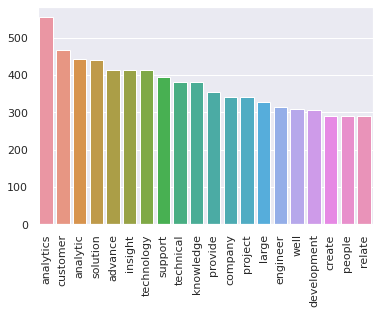

In [10]:
# Visualize most common words.

g = sns.barplot(top_20.sort_values(ascending=False)[:20].index, top_20.sort_values(ascending=False)[:20].values)
g.set_xticklabels(g.get_xticklabels(), rotation=90);

## 5) Use Scikit-Learn's tfidfVectorizer to get a TF-IDF feature matrix

In [11]:
# Instantiate vectorizer object
tfidf = TfidfVectorizer(tokenizer = my_tokenizer,
                        ngram_range = (1, 2),
                        min_df = 5, 
                        max_df = 0.5)
                        

# Create a vocabulary and tf-idf score per document
dtm = tfidf.fit_transform(df['text'])

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())

# View Feature Matrix as DataFrame
print(dtm.shape)
dtm.head()

(426, 4785)


,+,1+,1+ year,1-2,2+,2+ year,2-5,3+,3+ year,3-5,...,yes,york,york city.,york office,you'll,you'll need,you're,you've,you.,|
0,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.073358,0.073358,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.000000,0.0,0.214903,0.222964,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6) Create a NearestNeighbor Model. Write the description of your ideal datascience job and query your job listings. 

In [12]:
# Query documents for similar entries.

nn = NearestNeighbors(n_neighbors=5, algorithm='kd_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='kd_tree', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                 radius=1.0)

In [13]:
nn.kneighbors([dtm.iloc[123].values])

(array([[0.        , 0.        , 1.25515077, 1.26763027, 1.27351614]]),
 array([[123,  23, 140, 314, 256]]))

In [14]:
# Random pic - this entry is in the food industry.

print(df['text'][123])

motiion is a technology and data company for the food industry. we believe in transparency, diversity, merit and fostering a culture of accountability, personal impact and career growth.  as a member of the first product engineering team at motiion you have will have a unique opportunity to turning previously scattered and inconsistently structured data into directly actionable food industry insights to reduce waste, increase freshness and much more.  you have a proven track record of reading data and making solid conclusions. you know both the art and science of analytics - now only do you know how to find answers in the data, you also know which questions should be asked in the first place and what data might could help us further bolster our conclusions. you love engaging with customers, learn about their challenges and then dive into the data to see how to solve them!  we are building a product engineering team with a breadth of combined experiences so that we can collaboratively b

In [15]:
# This is the closest entry. Also in food industry. 

print(df['text'][140])

*****only local candidates will be consider for this role*****  who we are!  hi, we are chewse! hundreds of offices work with us to run their employee meal programs and culture services. on a monthly basis, we serve over 19,000 people. chewse delivers family-style office meals from the best local restaurants. we take on the burden of planning group meals, so companies large and small can focus on doing great work, with amazing people, on time. we outperform our competition around three core value propositions. 1) curated menus, 2) local restaurants, and 3) consistent experience.  we are a unique little team that is constantly experimenting with the best ways to have a fun, fulfilling, and productive culture. if you want to be part of a team that is paving the way for the culture as a service (caas) industry, and working on big hairy problems in order to help facilitate authentic human connection, then please reach out to us. the work is not easy, but the positive impact is real. every 

## Stretch Goals

 - Try different visualizations for words and frequencies - what story do you want to tell with the data?
 - Scrape Job Listings for the job title "Data Analyst". How do these differ from Data Scientist Job Listings
 - Try and identify requirements for experience specific technologies that are asked for in the job listings. How are those distributed among the job listings?
 - Use a clustering algorithm to cluster documents by their most important terms. Do the clusters reveal any common themes?
  - **Hint:** K-means might not be the best algorithm for this. Do a little bit of research to see what might be good for this. Also, remember that algorithms that depend on Euclidean distance break down with high dimensional data.
 - Create a labeled dataset - which jobs will you apply for? Train a model to select the jobs you are most likely to apply for. :) 